In [1]:
from typing import Any, cast

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from data.attribute import YEAR_ATTR, IS_CITIZEN_ATTR, AGE_ATTR, SEX_ATTR, COMMUNE_SIZE_ATTR, SEX_MALE, SEX_FEMALE, \
    POPULATION_ATTR
from data.error import infinite_weighted_error_margin, infinite_classical_error_margin, kish_effective_sample_size, \
    finite_weighted_error_margin
from data.selects import apply_age_smoothing, apply_demographic_correction

In [2]:
from data.selects import get_fors_selects
from data.population import get_bfs_population_cga

selects_df = get_fors_selects()
population_df = get_bfs_population_cga()

In [3]:
year = selects_df[YEAR_ATTR].max()
electorate_year_df = population_df[
    (population_df[YEAR_ATTR] == year) &
    (population_df[IS_CITIZEN_ATTR]) &
    (population_df[AGE_ATTR] >= 18)
    ]
raw_selects_year_df = selects_df[selects_df[YEAR_ATTR] == year].dropna(axis=1, how='all')
selects_year_df = apply_demographic_correction(
    apply_age_smoothing(raw_selects_year_df),
    electorate_year_df,
)

assert year == 2019

In [4]:
from pandas.core.groupby import DataFrameGroupBy


def tvd(distribution: pd.Series, reference: pd.Series) -> float:
    """Total Variation Distance"""
    return 0.5 * (distribution - reference).abs().sum()


def mean_participation(selects: pd.DataFrame) -> pd.Series:
    has_participated = selects['vp1'] == 'yes'
    weights_sum = selects['weightc'].sum()
    if weights_sum == 0:
        return pd.Series({'Value': np.nan, 'Error': np.nan})
    return pd.Series({
        'Value': (has_participated * selects['weightc']).sum() / weights_sum,
        'Error': infinite_weighted_error_margin(has_participated, selects['weightc']),
    }, name='Participation')


def mean_interest(selects: pd.DataFrame) -> float:
    weights_sum = selects['weightc'].sum()
    interest = selects['pi1'].copy().cat.add_categories(['na']).fillna('na')
    return 0 if weights_sum == 0 else selects['weightc'].groupby(interest, observed=False).sum() / weights_sum


def get_mean_participation(group_by: DataFrameGroupBy) -> pd.DataFrame:
    return cast(pd.DataFrame, group_by.apply(mean_participation, include_groups=False))


def get_mean_interest(group_by: DataFrameGroupBy) -> pd.Series:
    return cast(pd.Series, group_by.apply(mean_interest, include_groups=False))


def get_population_ration(group_by: DataFrameGroupBy) -> pd.Series:
    population = group_by['weightc'].sum()
    population /= population.sum()
    return population


def describe_participation_extremes(series: pd.Series):
    """Print the lowest and highest participation values in a series."""
    attr_name = ' / '.join(map(str, series.index.names)) \
        if isinstance(series.index, pd.MultiIndex) else \
        series.index.name
    print(f"Participation Extremes by {attr_name}:")

    minimum, maximum = series.min(), series.max()
    min_idx = series.idxmin()
    max_idx = series.idxmax()
    min_label = ' / '.join(str(x) for x in min_idx) if isinstance(min_idx, tuple) else min_idx
    max_label = ' / '.join(str(x) for x in max_idx) if isinstance(max_idx, tuple) else max_idx
    print(f'  Lowest ({min_label}): {minimum * 100:0.2f}% ({minimum / maximum:0.2f}x of highest)')
    print(f'  Highest ({max_label}): {maximum * 100:0.2f}% ({maximum / minimum:0.2f}x of lowest)')


def plot_attribute(attr: Any, group_by: DataFrameGroupBy):
    participation = get_mean_participation(group_by)
    population = group_by['weightc'].sum()
    population /= population.sum()
    interest = group_by.apply(mean_interest, include_groups=False)

    fig = plt.figure(figsize=(12, 5))
    fig.suptitle(f'Demographics by {attr}')
    grid = fig.add_gridspec(2, 2)
    plot_participation(
        participation, ax=fig.add_subplot(grid[0, 0]),
        # Already labeled on the population plot
        xticks=[], xlabel=''
    )
    plot_population(
        population,
        ax=fig.add_subplot(grid[1, 0]),
        xlabel=attr,
    )
    plot_interest_single(
        interest, ax=fig.add_subplot(grid[:, 1]),
        participation=participation,
        rot=90, xlabel=attr,
    )


def plot_interest_single(interest: pd.Series, *, participation: pd.Series = None, ax: plt.Axes = None, **kwargs):
    ax = interest.plot(
        kind='bar', stacked=True, ylim=(0, 1),
        title='Political Interest',
        ylabel='Proportion',
        ax=ax,
    )
    participation['Value'].plot(
        marker='.', linestyle='none', color='black', ax=ax,
        # Last plot call, so will overwrite previous axis settings
        **kwargs
    )
    ax.legend(title='Political Interest', loc='center left', bbox_to_anchor=(1, 0.5))
    return ax


def plot_interest_multiple(interest: pd.DataFrame, **kwargs):
    return interest.plot(
        kind='bar',
        title='Political Interest',
        ylabel='Proportion',
        yerr=interest,
        **kwargs
    )


def _maybe_label_bars(ax: plt.Axes, values: pd.Series | pd.DataFrame):
    if (not isinstance(values, pd.Series) and len(values.columns) > 1) or len(values) > 10:
        return
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f'{v:.2f}', ha='center')


def plot_participation(
        participation: pd.DataFrame, *,
        title: str = 'Participation',
        **kwargs
):
    ax = participation['Value'].plot(
        kind='bar',
        title=title,
        yerr=participation['Error'],
        **kwargs
    )
    ax.axhline(REAL_2019_TURNOUT, color='red', ls='--')
    _maybe_label_bars(ax, participation['Value'])
    if isinstance(participation.columns, pd.MultiIndex):
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return ax


def plot_population(
        population: pd.Series | pd.DataFrame, title: str = 'Population', **kwargs
):
    ax = population.plot(kind='bar', title=title, **kwargs)
    _maybe_label_bars(ax, population)
    return ax


def format_uncertain_value(value: float, error_margin: float) -> str:
    return f"{value:.3f}±{error_margin:.3f}"

In [5]:
REAL_2019_TURNOUT = 0.451
print(f'Selects turnout: {format_uncertain_value(*mean_participation(selects_year_df))}')
print(f'Raw selects turnout: {format_uncertain_value(*mean_participation(raw_selects_year_df))}')
print(f'BFS turnout: {REAL_2019_TURNOUT:.3f}')


def _correct_participation(selects: pd.DataFrame) -> pd.DataFrame:
    turnout = mean_participation(selects)['Value']
    corrected = selects.copy()
    voted_mask = corrected['vp1'] == 'yes'
    corrected.loc[voted_mask, 'weightc'] *= REAL_2019_TURNOUT / turnout
    corrected.loc[~voted_mask, 'weightc'] *= (1 - REAL_2019_TURNOUT) / (1 - turnout)
    return corrected


corrected_selects_year_df = _correct_participation(selects_year_df)
corrected_raw_selects_year_df = _correct_participation(raw_selects_year_df)
print(f'Corrected selects turnout: {format_uncertain_value(*mean_participation(corrected_selects_year_df))}')
print(f'Corrected raw selects turnout: {format_uncertain_value(*mean_participation(corrected_raw_selects_year_df))}')

Selects turnout: 0.710±0.006
Raw selects turnout: 0.717±0.015
BFS turnout: 0.451
Corrected selects turnout: 0.451±0.007
Corrected raw selects turnout: 0.451±0.018


Participation Extremes by pi1:
  Lowest (not interested at all): 5.83% (0.07x of highest)
  Highest (very interested): 82.43% (14.15x of lowest)


<Axes: title={'center': 'Participation'}, xlabel='pi1'>

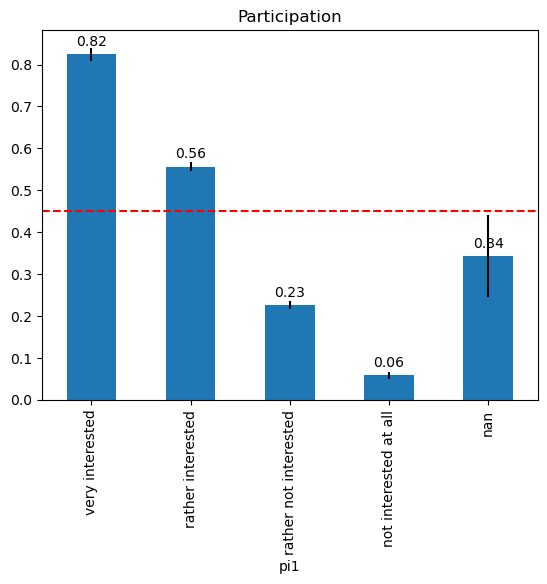

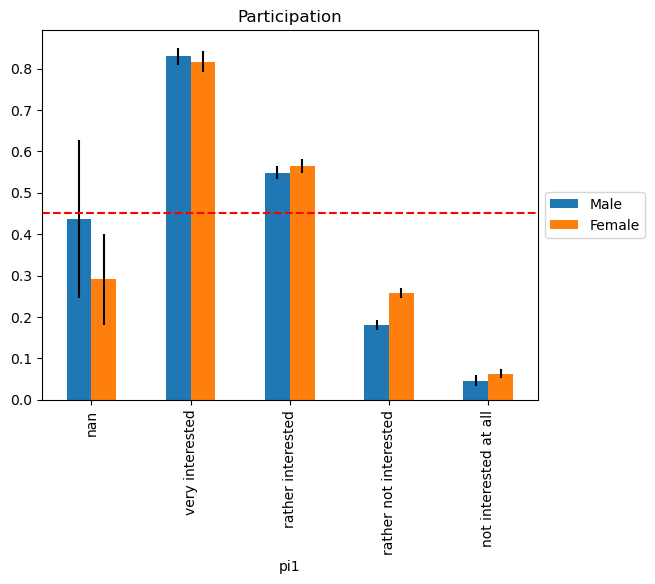

In [6]:
interest_participation = get_mean_participation(corrected_selects_year_df.groupby('pi1', dropna=False, observed=False))
interest_sex_participation = get_mean_participation(
    corrected_selects_year_df.groupby([SEX_ATTR, 'pi1'], dropna=False, observed=False)) \
    .unstack(level=SEX_ATTR)

describe_participation_extremes(interest_participation['Value'])
plot_participation(interest_participation)
plot_participation(interest_sex_participation)

Participation Extremes by pk6:
  Lowest (low knowledge): 14.84% (0.17x of highest)
  Highest (high knowledge): 86.06% (5.80x of lowest)


<Axes: title={'center': 'Participation'}, xlabel='pk6'>

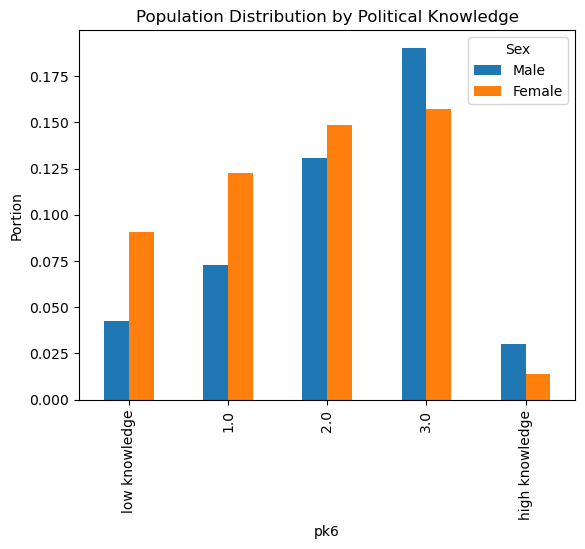

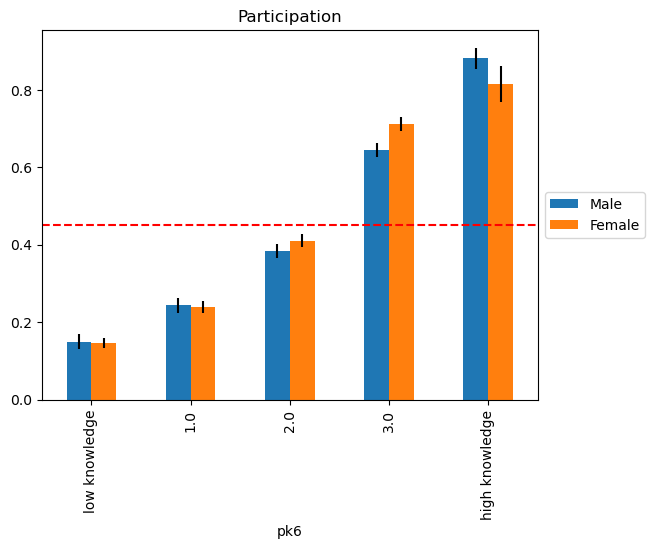

In [7]:
describe_participation_extremes(
    get_mean_participation(corrected_selects_year_df.groupby('pk6', observed=True, dropna=False))['Value']
)

knowledge_sex_grouping = corrected_selects_year_df.groupby([SEX_ATTR, 'pk6'], observed=True, dropna=False)
get_population_ration(knowledge_sex_grouping).unstack(level=SEX_ATTR).plot(
    kind='bar',
    title='Population Distribution by Political Knowledge',
    ylabel='Portion'
)
plot_participation(get_mean_participation(knowledge_sex_grouping).unstack(level=SEX_ATTR))

In [8]:
# Get all possible attributes to analyze
demographic_attributes = [
    col for col in corrected_selects_year_df.columns
    if not isinstance(col, str) or col in (
        'maritals',  # Marital status
        'religion',  # Religion
        'churchg',  # Church attendance
        'class8',  # Social class
        'vp2',  # Participated 4 years ago
        'hvdn2b',  # National council real or hypothetical voting decision
    ) or any(map(col.startswith, (
        'educ',  # Education
        'income',  # Income
        'sg',  # Sociodemographic geography
        'sh',  # Sociodemographic household
        'sc',  # Social class
        'ses',  # Economic situation
        'sp',  # Social participation
    )))
]

# Analyze each attribute
attribute_metrics = []
attribute_groupings = {}
for attribute in demographic_attributes:
    series = corrected_selects_year_df[attribute]

    # Determine what to group by
    unique_count = series.nunique(dropna=False)
    if unique_count <= 20 or isinstance(series.dtype, pd.CategoricalDtype):
        group_attr = attribute
    elif pd.api.types.is_numeric_dtype(series):
        group_attr = pd.cut(series, bins=12)
    else:
        print(
            f'Skipping "{attribute}". '
            f'Attribute has too many unique values ({unique_count}) '
            f'and is not numeric ({series.dtype}).'
        )
        continue

    # Create grouping
    grouping = attribute_groupings[attribute] = corrected_selects_year_df \
        .groupby(group_attr, observed=True, dropna=False)
    group_participation = get_mean_participation(grouping)
    group_size = grouping['weightc'].sum()
    group_participants_size = group_size * group_participation['Value']
    group_size /= group_size.sum()
    group_participants_size /= group_participants_size.sum()

    # Calculate metrics
    min_participation = group_participation['Value'].min()
    max_participation = group_participation['Value'].max()
    attribute_metrics.append({
        'attribute': attribute,
        'min_participation': min_participation,
        'max_participation': max_participation,
        'max_min_ratio': max_participation / min_participation if min_participation > 0 else np.nan,
        'participation_uniformity': tvd(group_size, group_participants_size),
        'population_uniformity': tvd(group_size, np.full_like(group_size, 1 / len(group_size))),
        'valid_proportion': series.count() / len(series),
        'group_count': grouping.ngroups,
        'is_numeric': pd.api.types.is_numeric_dtype(series),
    })
metrics_df = pd.DataFrame(attribute_metrics).set_index('attribute') \
    .sort_values('participation_uniformity', ascending=False)

metrics_df

,min_participation,max_participation,max_min_ratio,participation_uniformity,population_uniformity,valid_proportion,group_count,is_numeric
attribute,,,,,,,,
vp2,0.185366,0.736796,3.974810,0.285334,0.415742,0.993537,4,False
sg4,0.219387,0.942010,4.293829,0.283971,0.582627,0.554540,27,False
income3,0.255624,0.555829,2.174401,0.126831,0.391495,0.977641,4,False
hvdn2b,0.053389,0.878723,16.458987,0.123992,0.473074,0.910283,17,False
educ,0.271961,0.596644,2.193863,0.100418,0.368914,0.977496,10,False
ses1,0.347385,0.542747,1.562378,0.098337,0.463827,0.985743,4,False
income_hh,0.330077,0.557381,1.688639,0.083354,0.092680,0.663782,6,False
sch2_isco08,0.334279,0.558573,1.670979,0.083172,0.298296,0.873395,13,True
class8,0.323068,0.627661,1.942818,0.082688,0.158710,0.866425,9,False


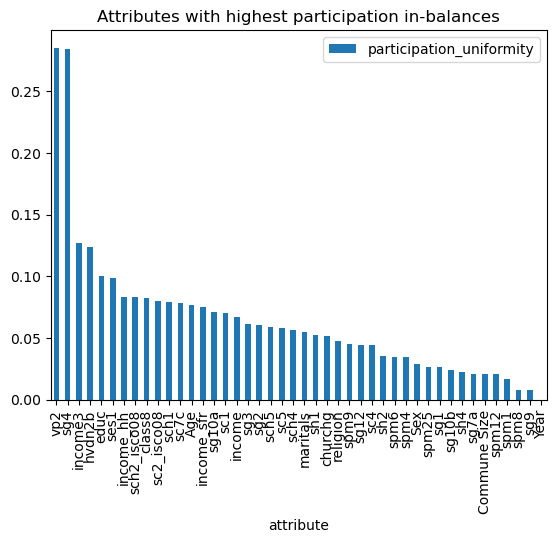

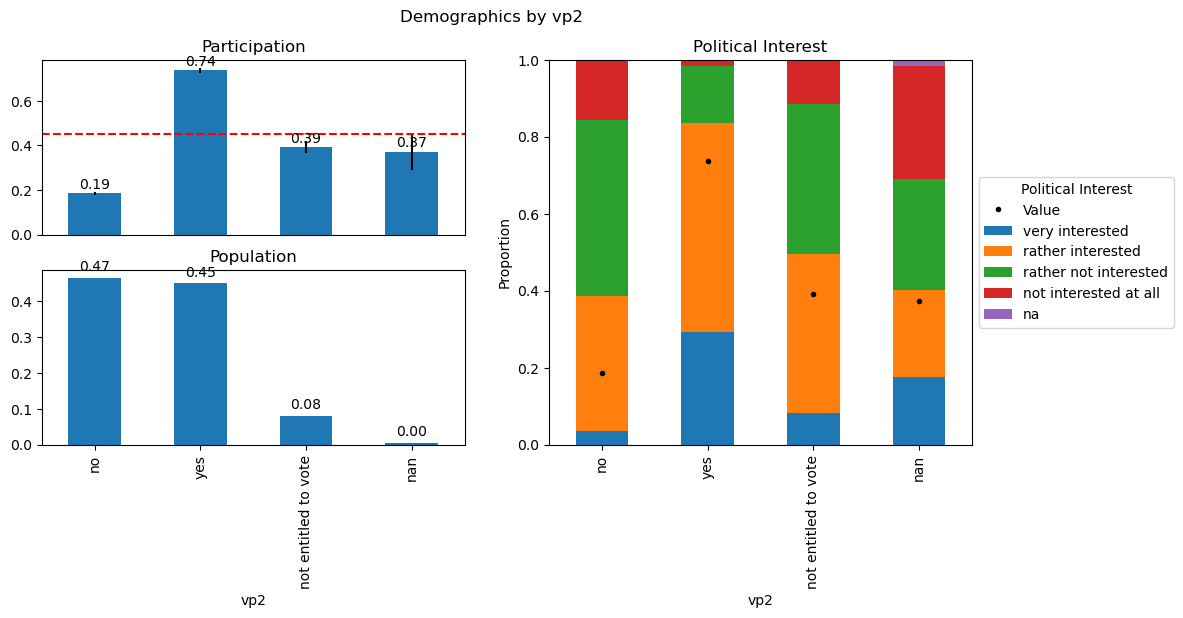

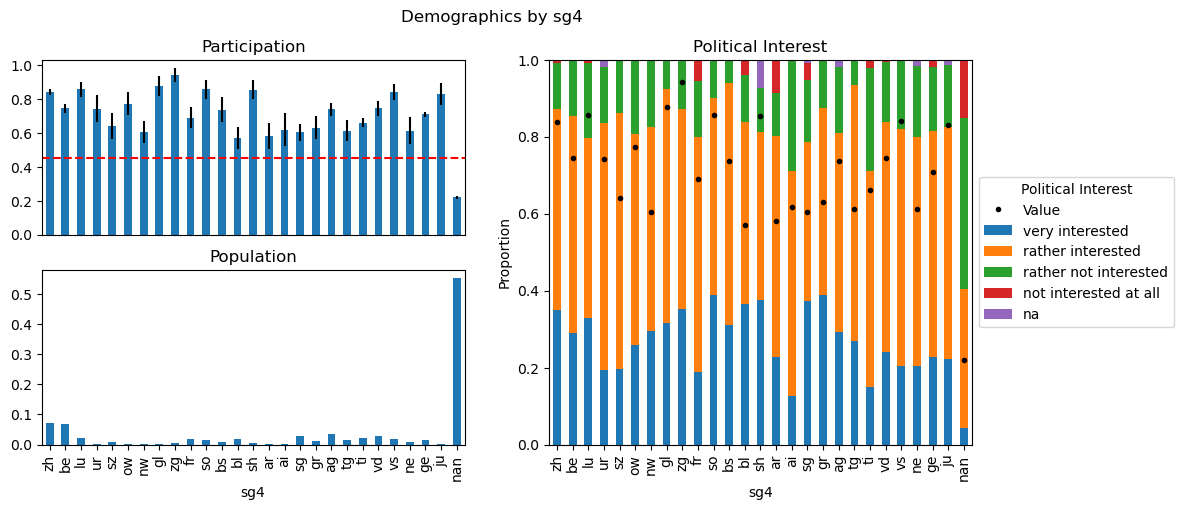

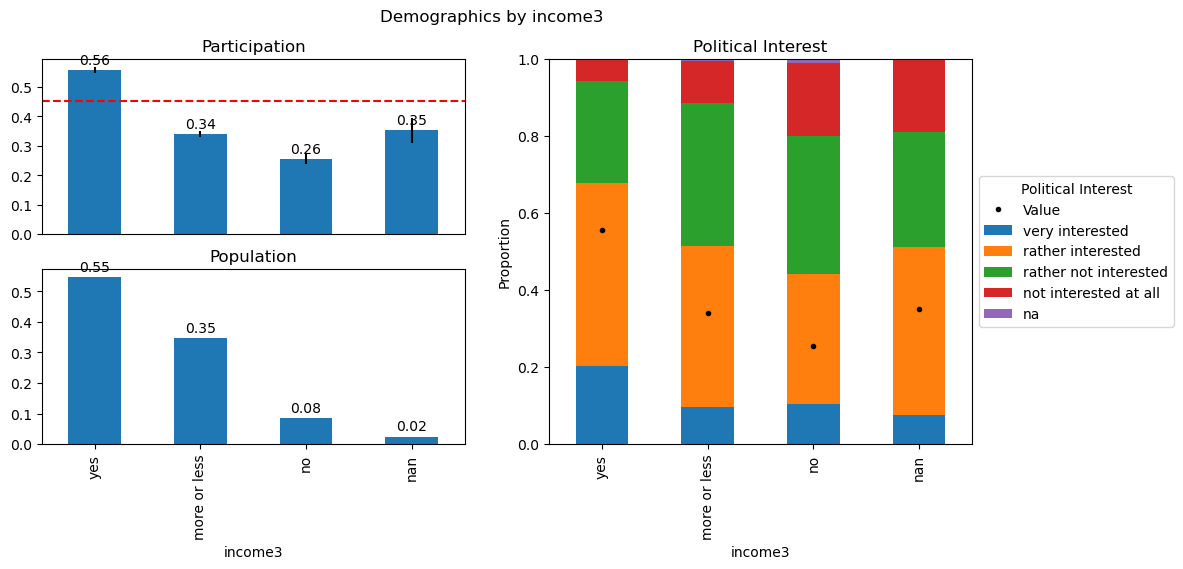

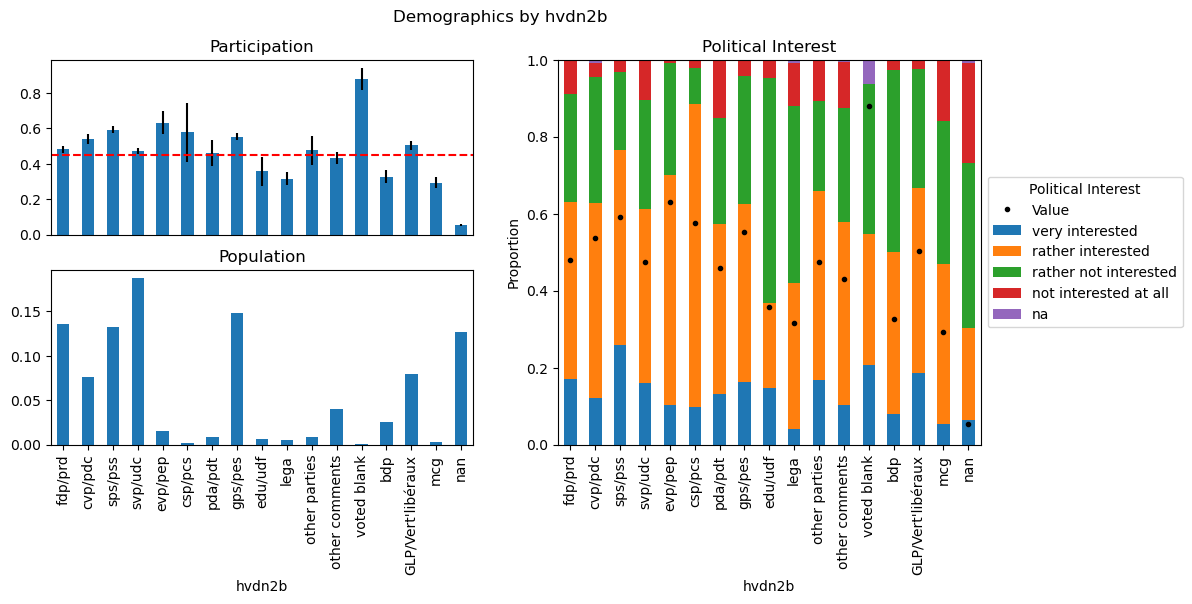

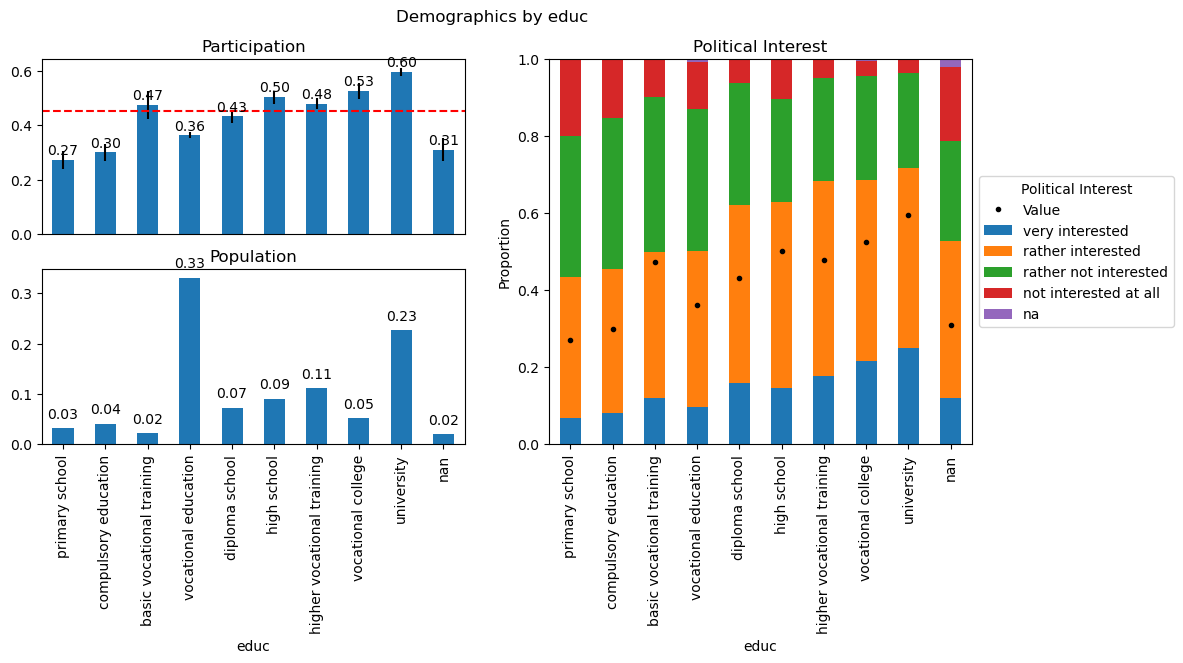

In [9]:
analyze_candidates = metrics_df[metrics_df['valid_proportion'] > 0.5]
analyze_candidates.plot(
    y='participation_uniformity', kind='bar',
    title='Attributes with highest participation in-balances'
)
plt.show()

for attribute, metrics in analyze_candidates.head(5).iterrows():
    plot_attribute(attribute, attribute_groupings[attribute])

Participation Extremes by Sex:
  Lowest (Female): 42.63% (0.89x of highest)
  Highest (Male): 47.93% (1.12x of lowest)


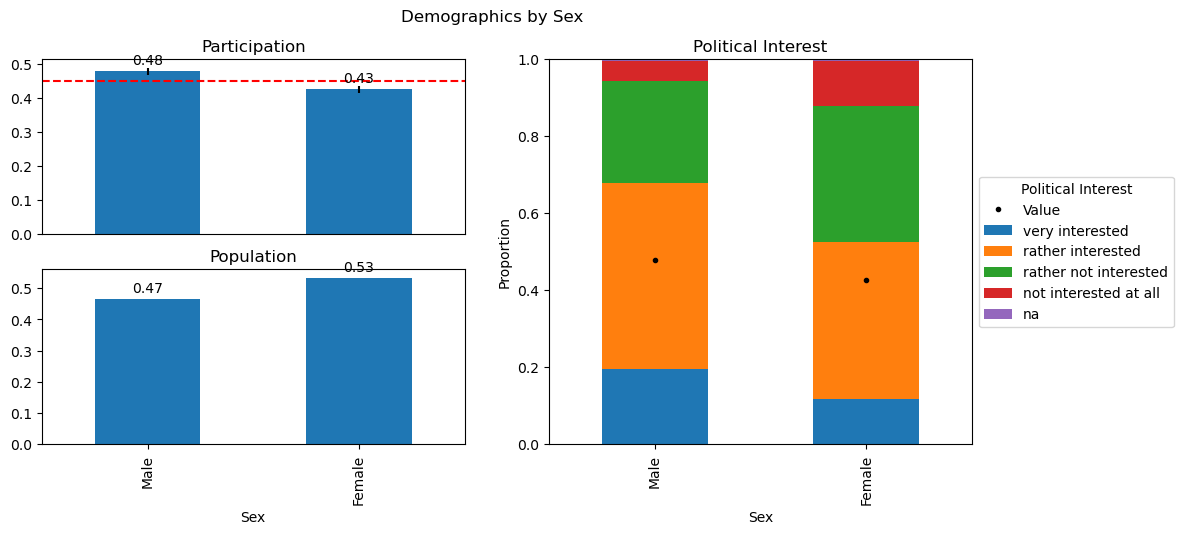

In [10]:
sex_grouping = corrected_selects_year_df.groupby(SEX_ATTR, observed=False)
plot_attribute(SEX_ATTR, sex_grouping)
describe_participation_extremes(get_mean_participation(sex_grouping)['Value'])

In [11]:
# Group very old people into a single group because of their small sample size
MAX_AGE = 90
age_grouping = corrected_selects_year_df[AGE_ATTR].clip(upper=MAX_AGE)
age_electorate = electorate_year_df.groupby(electorate_year_df[AGE_ATTR].clip(upper=MAX_AGE))[POPULATION_ATTR].sum()

Participation Extremes by Age:
  Lowest (28): 33.07% (0.54x of highest)
  Highest (70): 61.30% (1.85x of lowest)
Participation Extremes by Age / Sex:
  Lowest (30 / Female): 30.14% (0.41x of highest)
  Highest (70 / Male): 73.37% (2.43x of lowest)


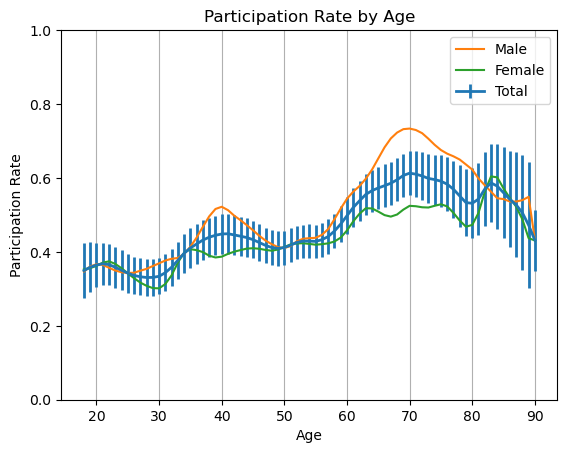

In [12]:
age_sex_participation = corrected_selects_year_df.groupby([age_grouping, SEX_ATTR], dropna=False, observed=True) \
    .apply(mean_participation, include_groups=False)
age_participation = corrected_selects_year_df.groupby(age_grouping).apply(mean_participation)

ax = age_participation['Value'].rename('Total').plot(linewidth=2, yerr=age_participation['Error'])
age_sex_participation['Value'].unstack(level=SEX_ATTR).plot(
    ylim=(0, 1),
    title='Participation Rate by Age',
    ylabel='Participation Rate',
    grid=True,
    ax=ax
)
ax.grid(axis='y')
ax.legend()

describe_participation_extremes(age_participation['Value'])
describe_participation_extremes(age_sex_participation['Value'])

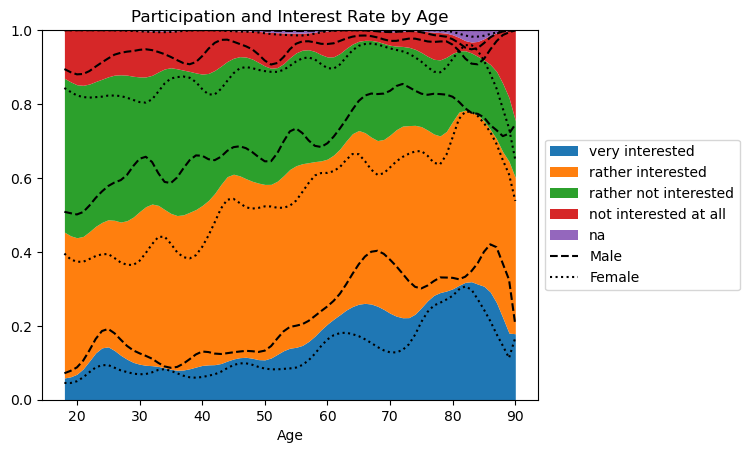

In [13]:
_SEX_LINE_STYLE = {
    SEX_MALE: '--',
    SEX_FEMALE: ':'
}

age_interest = corrected_selects_year_df.groupby(age_grouping).apply(mean_interest)
age_sex_interest = corrected_selects_year_df.groupby([age_grouping, SEX_ATTR], dropna=False, observed=True) \
    .apply(mean_interest, include_groups=False).unstack(level=SEX_ATTR)
available_sex = corrected_selects_year_df[SEX_ATTR].unique()

ax = age_interest.plot(
    kind='area', stacked=True, linewidth=0,
    title='Participation and Interest Rate by Age',
    ylim=(0, 1)
)
for sex in available_sex:
    age_sex_interest.xs(sex, level=SEX_ATTR, axis=1) \
        .plot(color='black', linestyle=_SEX_LINE_STYLE[sex], stacked=True, ax=ax)

# Modify the legend to show the correct labels
handles, labels = ax.get_legend_handles_labels()
area_handles = handles[:len(age_interest.columns)]  # Area plot handles
sex_handles = [
    handles[len(area_handles) + i * len(age_interest.columns)]
    for i in range(len(age_sex_interest.columns.get_level_values(SEX_ATTR).unique()))
]
ax.legend(
    area_handles + sex_handles,
    labels[:len(age_interest.columns)] + list(available_sex),
    loc='center left', bbox_to_anchor=(1, 0.5)
)

Participation Extremes by sg3:
  Lowest (ne): 31.09% (0.42x of highest)
  Highest (sh): 73.84% (2.38x of lowest)


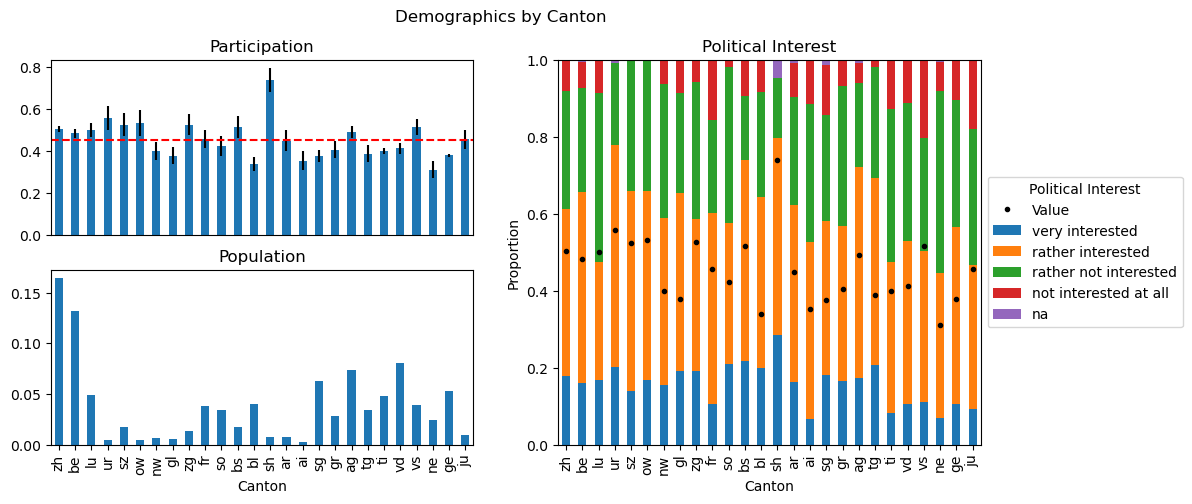

In [14]:
# TODO: Compare and correct with ground truth
canton_grouping = corrected_selects_year_df.groupby('sg3', observed=True)
plot_attribute('Canton', canton_grouping)
describe_participation_extremes(get_mean_participation(canton_grouping)['Value'])

<Axes: title={'center': 'Participation'}>

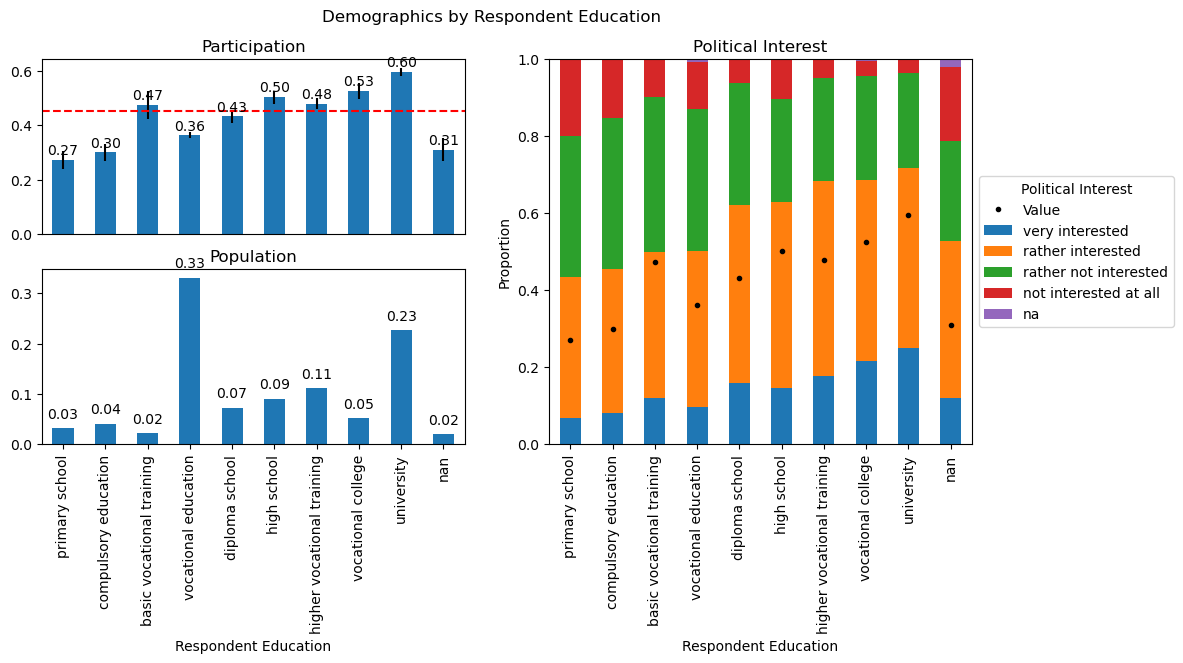

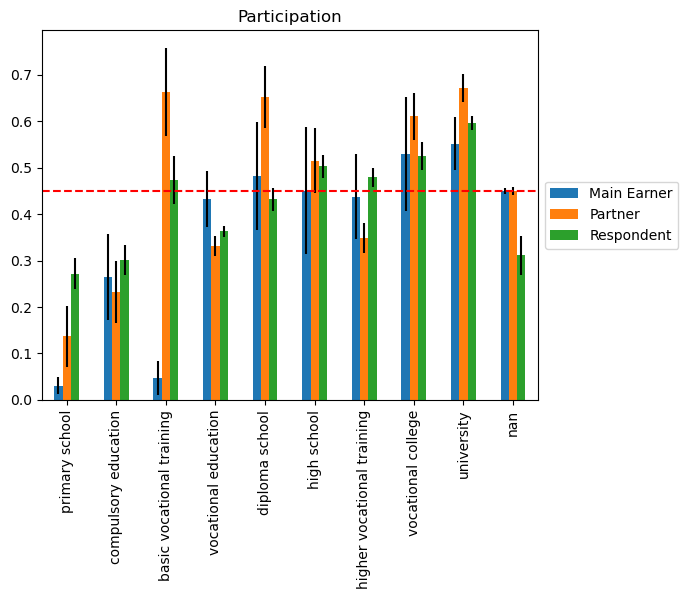

In [15]:
education_grouping = corrected_selects_year_df.groupby('educ', observed=True, dropna=False)
plot_attribute('Respondent Education', education_grouping)
plot_participation(
    pd.concat({
        'Main Earner': get_mean_participation(corrected_selects_year_df.groupby('educh', observed=True, dropna=False)),
        'Partner': get_mean_participation(corrected_selects_year_df.groupby('educp', observed=True, dropna=False)),
        'Respondent': get_mean_participation(education_grouping),
    }, axis=1).swaplevel(axis=1)
)

Participation Extremes by sc1:
  Lowest (unemployed): 21.86% (0.38x of highest)
  Highest (retired): 57.66% (2.64x of lowest)


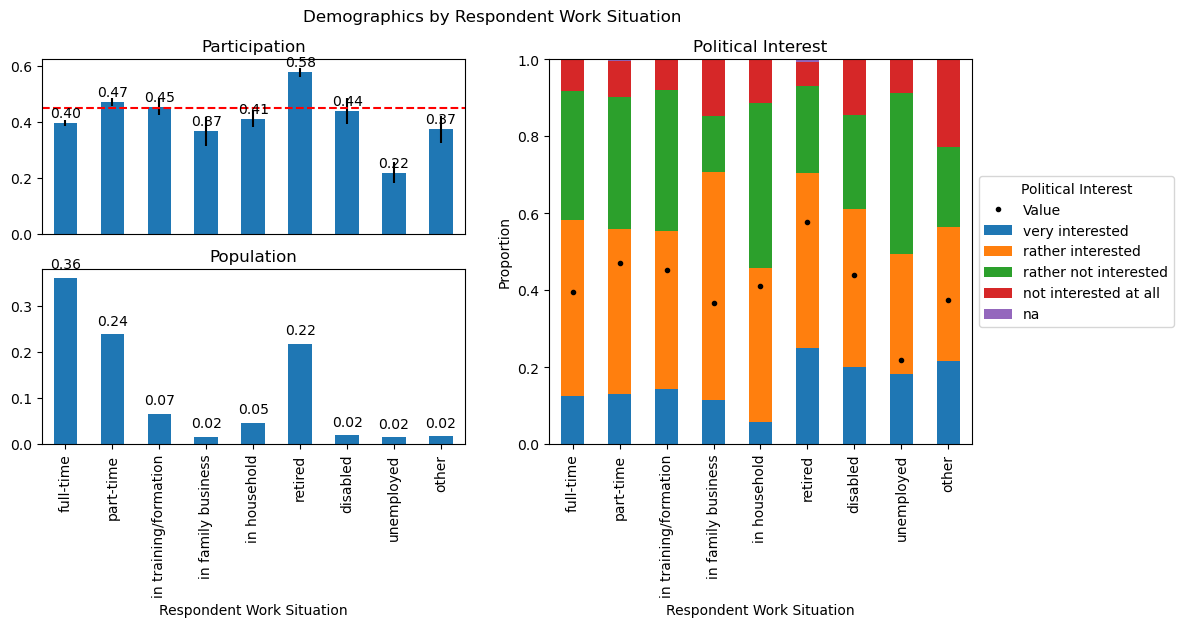

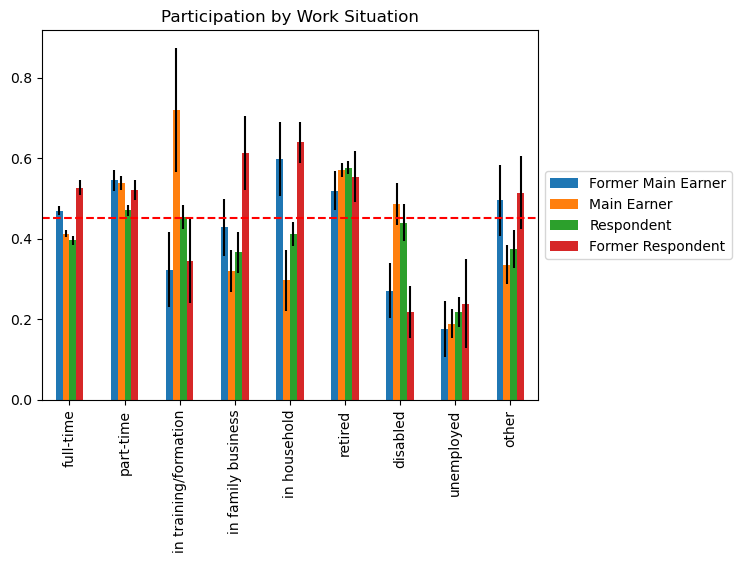

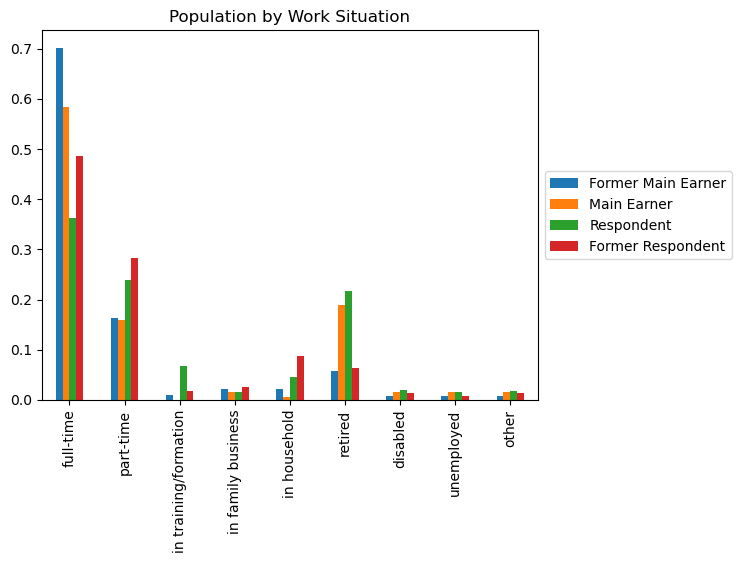

In [16]:
work_situation_grouping = corrected_selects_year_df.groupby('sc1', observed=True)
work_situation_participation = get_mean_participation(work_situation_grouping)
former_work_situation_grouping = corrected_selects_year_df.groupby('sc1a', observed=True)
main_earner_work_situation_grouping = corrected_selects_year_df.groupby('sch1', observed=True)
former_main_earner_work_situation_grouping = corrected_selects_year_df.groupby('sch1a', observed=True)

describe_participation_extremes(work_situation_participation['Value'])
plot_attribute('Respondent Work Situation', work_situation_grouping)
ax = plot_participation(
    pd.concat({
        'Former Main Earner': get_mean_participation(former_main_earner_work_situation_grouping),
        'Main Earner': get_mean_participation(main_earner_work_situation_grouping),
        'Respondent': work_situation_participation,
        'Former Respondent': get_mean_participation(former_work_situation_grouping),
    }, axis=1).swaplevel(axis=1),
    title='Participation by Work Situation',
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = plot_population(
    pd.concat([
        get_population_ration(former_main_earner_work_situation_grouping).rename('Former Main Earner'),
        get_population_ration(main_earner_work_situation_grouping).rename('Main Earner'),
        get_population_ration(work_situation_grouping).rename('Respondent'),
        get_population_ration(former_work_situation_grouping).rename('Former Respondent'),
    ], axis=1),
    title='Population by Work Situation',
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

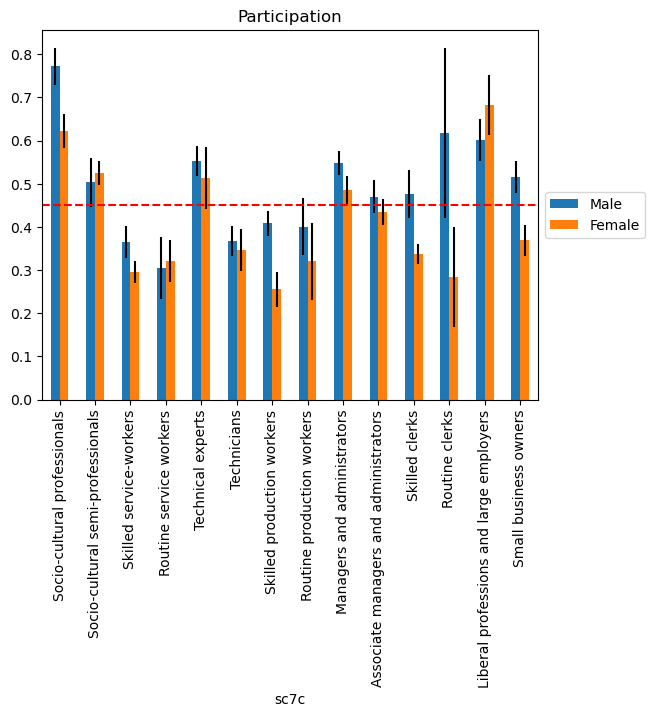

Participation Extremes by sc7c:
  Lowest (Routine service workers): 31.63% (0.46x of highest)
  Highest (Socio-cultural professionals): 68.42% (2.16x of lowest)
Participation Extremes by Sex / sc7c:
  Lowest (Female / Skilled production workers): 25.53% (0.33x of highest)
  Highest (Male / Socio-cultural professionals): 77.22% (3.02x of lowest)


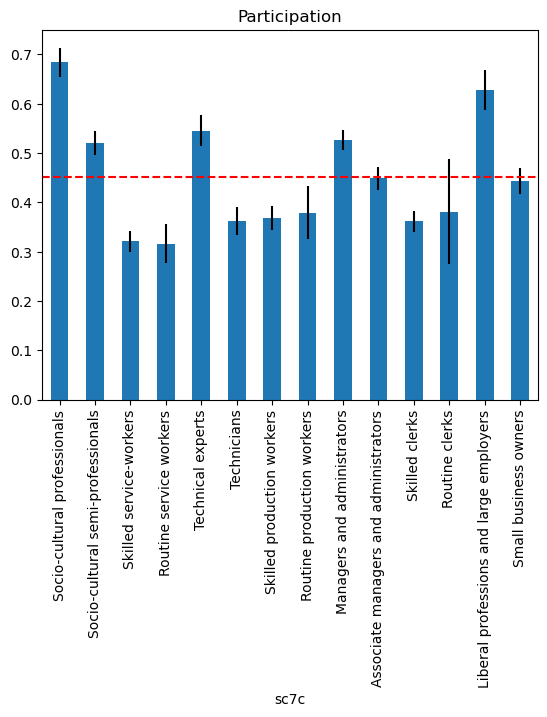

In [19]:
social_class_participation = get_mean_participation(corrected_selects_year_df.groupby('sc7c', observed=True))
social_class_sex_participation = get_mean_participation(corrected_selects_year_df.groupby([SEX_ATTR, 'sc7c'], observed=True))

plot_participation(social_class_sex_participation.unstack(level=SEX_ATTR))
plt.show()
plot_participation(social_class_participation)

describe_participation_extremes(social_class_participation['Value'])
describe_participation_extremes(social_class_sex_participation['Value'])

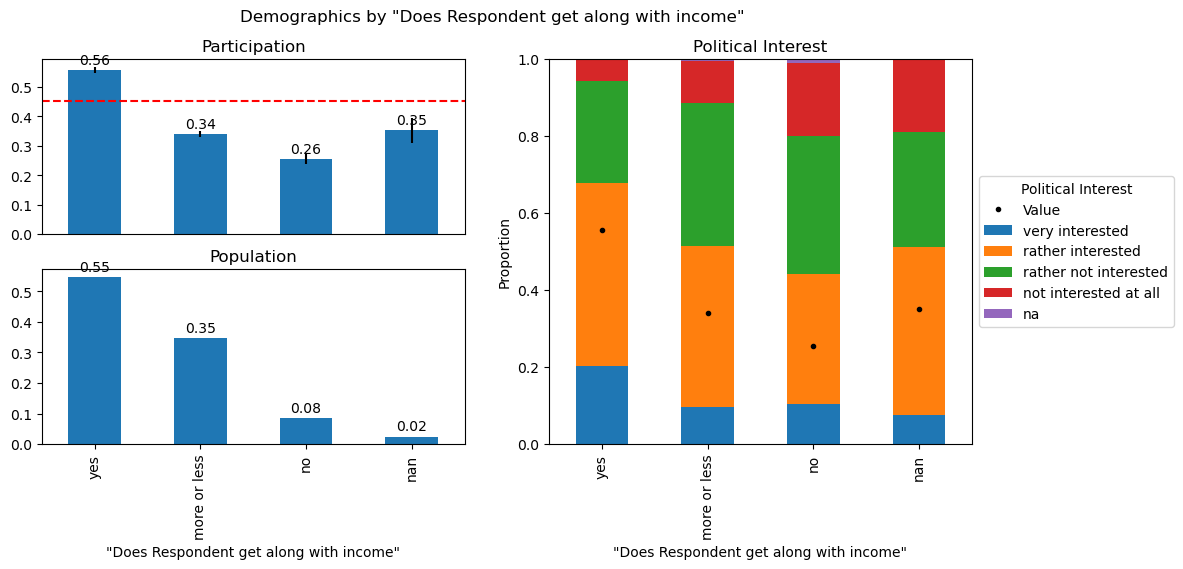

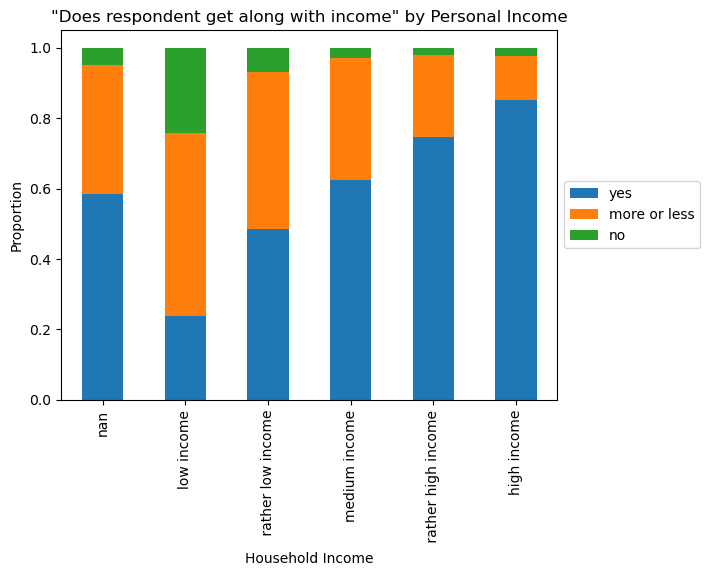

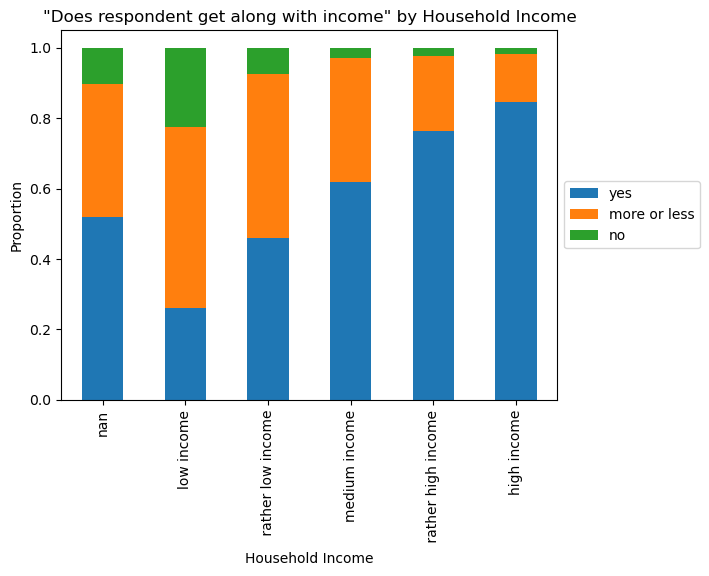

In [18]:
def _plot_income3_distribution(attribute: Any, attribute_name: str):
    income_distribution = pd.crosstab(
        corrected_selects_year_df[attribute],
        corrected_selects_year_df['income3'],
        values=corrected_selects_year_df['weightc'],
        aggfunc='sum',
        normalize='index',
        dropna=False
    )
    ax = income_distribution.plot(
        kind='bar',
        stacked=True,
        title=f'"Does respondent get along with income" by {attribute_name}',
        ylabel='Proportion',
        xlabel='Household Income'
    )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plot_attribute(
    '"Does Respondent get along with income"',
    corrected_selects_year_df.groupby('income3', observed=True, dropna=False)
)
_plot_income3_distribution('income', 'Personal Income')
_plot_income3_distribution('income_hh', 'Household Income')